## Grupo 23

**Nombre:** Raúl Miguel Carrero Martín 
**Nia**: 100451286 
**Grupo de clase**: 81

**Nombre:** Gonzalo Vela Sacristán
**Nia**: 100472334
**Grupo de clase**: 84

In [182]:
%pip install numpy
%pip install pandas
%pip install matplotlib
%pip install seaborn
%pip install pickle
%pip install time
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


You are using pip version 10.0.1, however version 24.0 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You are using pip version 10.0.1, however version 24.0 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You are using pip version 10.0.1, however version 24.0 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You are using pip version 10.0.1, however version 24.0 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


  Could not find a version that satisfies the requirement pickle (from versions: )
No matching distribution found for pickle
You are using pip version 10.0.1, however version 24.0 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


  Could not find a version that satisfies the requirement time (from versions: )
No matching distribution found for time
You are using pip version 10.0.1, however version 24.0 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You are using pip version 10.0.1, however version 24.0 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


# Importación de los datos y librerias

In [183]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
import time
from sklearn.datasets import make_blobs

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import style
style.use('ggplot') 


# Preprocesado y modelado
# ==============================================================================
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale, StandardScaler
from sklearn.metrics import silhouette_score, silhouette_samples
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.datasets import make_blobs
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch



## Importar los datos

In [184]:
data = pd.read_csv("data/stars_data.csv")
display(data)

# Copiamos los datos y los estandarizamos
# ==============================================================================
data_df = data[['Temperature', 'L', 'R', 'A_M', 'Color', 'Spectral_Class']].copy()

print("Cantidad de filas y columnas: ", data_df.shape)
print("Nombre de las columnas: ", data_df.columns)




,Temperature,L,R,A_M,Color,Spectral_Class
0,3068,0.002400,0.1700,16.12,Red,M
1,3042,0.000500,0.1542,16.60,Red,M
2,2600,0.000300,0.1020,18.70,Red,M
3,2800,0.000200,0.1600,16.65,Red,M
4,1939,0.000138,0.1030,20.06,Red,M
...,...,...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93,Blue,O
236,30839,834042.000000,1194.0000,-10.63,Blue,O
237,8829,537493.000000,1423.0000,-10.73,White,A
238,9235,404940.000000,1112.0000,-11.23,White,A


Cantidad de filas y columnas:  (240, 6)
Nombre de las columnas:  Index(['Temperature', 'L', 'R', 'A_M', 'Color', 'Spectral_Class'], dtype='object')


In [185]:
# Mostramos las columnas con valores nulos
print("Columnas con valores nulos: ")
print(data_df.isnull().sum())

Columnas con valores nulos: 
Temperature       0
L                 0
R                 0
A_M               0
Color             0
Spectral_Class    0
dtype: int64


In [186]:
# Mostramos las columnas con NaN
print("Columnas con NaN: ")
print(data_df.isna().sum())

Columnas con NaN: 
Temperature       0
L                 0
R                 0
A_M               0
Color             0
Spectral_Class    0
dtype: int64


In [187]:
# Describimos las variables
print("Estadísticas de las variables:")
print(data_df.describe())

Estadísticas de las variables:
        Temperature              L            R         A_M
count    240.000000     240.000000   240.000000  240.000000
mean   10497.462500  107188.361635   237.157781    4.382396
std     9552.425037  179432.244940   517.155763   10.532512
min     1939.000000       0.000080     0.008400  -11.920000
25%     3344.250000       0.000865     0.102750   -6.232500
50%     5776.000000       0.070500     0.762500    8.313000
75%    15055.500000  198050.000000    42.750000   13.697500
max    40000.000000  849420.000000  1948.500000   20.060000


# 1.- Kmeans 

In [188]:

def distancia(a, b):
    return np.sqrt(np.sum((a - b)**2))

def kmeans(datos, k, max_iter=100):
    np.random.seed(23)
    # Inicialización aleatoria de los centroides
    centroides_indices = np.random.choice(len(datos), k, replace=False)
    centroides = datos[centroides_indices]
    threshold = 0.001
    asignaciones = []

    for iteration in range(max_iter):
        # Asignar cada punto al centroide más cercano
        asignaciones = []
        for dato in datos:
            distancias = []
            for centroide in centroides:
                distancias.append(distancia(dato, centroide))
            asignacion = np.argmin(distancias)
            asignaciones.append(asignacion)

        # Actualizar los centroides
        nuevos_centroides = []
        for j in range(k):
            puntos_asignados = []
            for i in range(len(datos)):
                punto_asignado = [datos[i], asignaciones[i]]
                if punto_asignado[1] == j:
                    puntos_asignados.append(datos[i])
            nuevo_centroide = np.mean(puntos_asignados, axis=0)
            nuevos_centroides.append(nuevo_centroide)
        nuevos_centroides = np.array(nuevos_centroides)

        d_centroides = []
        for i in range(k):
            d_centroides.append(distancia(centroides[i], nuevos_centroides[i]))
        if np.max(d_centroides) < threshold:
            break

        centroides = nuevos_centroides
    print("Iteración final: ", iteration)
    print("Centroides finales: ", nuevos_centroides )
    return centroides, asignaciones

La función distancia(a, b) calcula la distancia euclidiana entre dos puntos en el espacio de características. Utiliza la función np.sqrt de NumPy para calcular la raíz cuadrada de la suma de los cuadrados de las diferencias entre las coordenadas de los puntos. La función kmeans(datos, k, max_iter=100) toma tres argumentos de entrada datos, klusters y máximas iteraciones. Primero se inicializa aleatoriamente un conjunto de centroides iniciales a partir de los datos proporcionados. Luego, se asignan todos los puntos de datos al centroide más cercano. Después, se actualizan los centroides calculando la media de todos los puntos asignados a cada centroide. Este proceso de asignación y actualización de centroides se repite hasta que se alcanza un criterio de detención. En este caso, el criterio de detención es que la diferencia entre los centroides antiguos y los nuevos sea menor que el threshold, o se alcanza el número máximo de iteraciones (max_iter)

Comparación

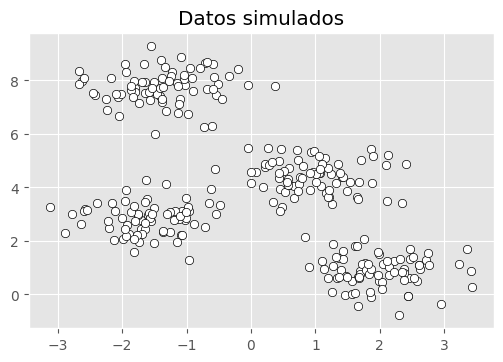

In [189]:
# Simulación de datos
X, y = make_blobs(
    n_samples    = 300,
    n_features   = 2,
    centers      = 4,
    cluster_std  = 0.60,
    shuffle      = True,
    random_state = 0
)

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.scatter(
    x = X[:, 0],
    y = X[:, 1],
    c = 'white',
    marker    = 'o',
    edgecolor = 'black',
)
ax.set_title('Datos simulados');

Simulamos datos con la función make blobs para probar nuestra función k-means

Iteración final:  3
Centroides finales:  [[ 0.94973532  4.41906906]
 [-1.58438467  2.83081263]
 [ 1.98258281  0.86771314]
 [-1.37324398  7.75368871]]


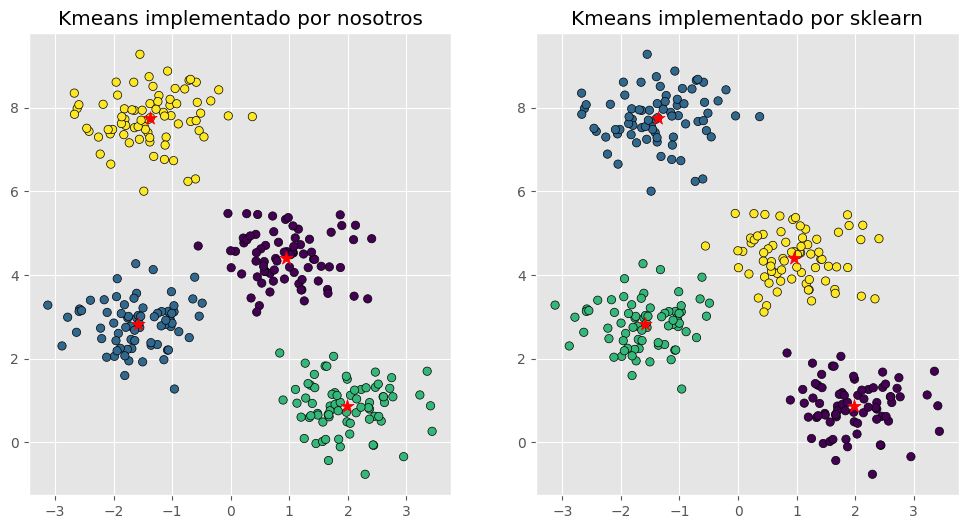

In [190]:
# Kmeans con 4 clusters
centroides, asignaciones = kmeans(X, 4)
# Con la función kmeans de sklearn
kmeans_sklearn = KMeans(n_clusters=4, random_state=23).fit(X)

# Representación gráfica
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].scatter(
    x = X[:, 0],
    y = X[:, 1],
    c = asignaciones,
    cmap = 'viridis',
    marker    = 'o',
    edgecolor = 'black',
)
ax[0].scatter(
    x = centroides[:, 0],
    y = centroides[:, 1],
    c = 'red',
    s = 100,
    marker = '*'
)
ax[0].set_title('Kmeans implementado por nosotros')

ax[1].scatter(
    x = X[:, 0],
    y = X[:, 1],
    c = kmeans_sklearn.labels_,
    cmap = 'viridis',
    marker    = 'o',
    edgecolor = 'black',
)
ax[1].scatter(
    x = kmeans_sklearn.cluster_centers_[:, 0],
    y = kmeans_sklearn.cluster_centers_[:, 1],
    c = 'red',
    s = 100,
    marker = '*'
)
ax[1].set_title('Kmeans implementado por sklearn');


Aquí observamos la diferencia de resultados con los datos simulados, entre nuestra función creada y la función k-means de skicit learn, vemos que a rangos generales son muy similares en los resultados

# 2.- Encoding de los datos categóricos

Primero observamos los valores de las variables categóricas

In [191]:
print("Valores de la columna Color: ")
print(data_df.Color.unique())

print("Valores de la columna Spectral_Class: ")
print(data_df.Spectral_Class.unique())

Valores de la columna Color: 
['Red' 'Blue White' 'White' 'Yellowish White' 'Blue white'
 'Pale yellow orange' 'Blue' 'Blue-white' 'Whitish' 'yellow-white'
 'Orange' 'White-Yellow' 'white' 'yellowish' 'Yellowish' 'Orange-Red'
 'Blue-White']
Valores de la columna Spectral_Class: 
['M' 'B' 'A' 'F' 'O' 'K' 'G']


Mapeamos los valores obtenidos de las columnas *Color* y *Spectral Class*.

In [192]:
# Establecemos una unificación de colores:
mapping_color = { 
    'Red': ['Red'],
    'Orange-Red': ['Orange-Red'],
    'Orange': ['Orange'],
    'Yellow-Orange': ['Pale yellow orange'],
    'Yellow': ['yellowish', 'Yellowish'],
    'White-Yellow': ['Yellowish White', 'yellow-white', 'White-Yellow'],
    'White': ['White', 'Whitish', 'white'],
    'Blue-White': ['Blue White', 'Blue white', 'Blue-white', 'Blue-White'],
    'Blue': ['Blue'],
}

# Establecemos una unificación de colores:
mapping_spectral = {
    'M': ['M'],
    'K': ['K'],
    'G': ['G'],
    'F': ['F'],
    'A': ['A'],
    'B': ['B'],
    'O': ['O'],
}

In [193]:
# Mapeamos los datos
for target_color, source_colors in mapping_color.items():
  data_df.loc[data_df.Color.isin(source_colors), 'Color'] = target_color

print("Valores de la columna Color: ")
print(data_df.Color.unique())

Valores de la columna Color: 
['Red' 'Blue-White' 'White' 'White-Yellow' 'Yellow-Orange' 'Blue' 'Orange'
 'Yellow' 'Orange-Red']


## 2.1.- One-Hot-Encoding

In [194]:
one_hot_df = data_df.copy()

encoder = OneHotEncoder()

# Ajustamos el codificador y transformamos las columnas
one_hot_encoded = encoder.fit_transform(one_hot_df[['Color', 'Spectral_Class']])

# Cogemos los nombres de las nuevas columnas
feature_names = encoder.get_feature_names_out(['Color', 'Spectral_Class'])

# Creamos un DataFrame con los datos transformados
one_hot_encoded_df = pd.DataFrame(one_hot_encoded.toarray(), columns=feature_names)

# Eliminamos las columnas originales
one_hot_df = one_hot_df.drop(columns=['Color', 'Spectral_Class'])

# Añadimos las nuevas columnas
one_hot_df = pd.concat([one_hot_df, one_hot_encoded_df], axis=1)

display(one_hot_df)


,Temperature,L,R,A_M,Color_Blue,Color_Blue-White,Color_Orange,Color_Orange-Red,Color_Red,Color_White,Color_White-Yellow,Color_Yellow,Color_Yellow-Orange,Spectral_Class_A,Spectral_Class_B,Spectral_Class_F,Spectral_Class_G,Spectral_Class_K,Spectral_Class_M,Spectral_Class_O
0,3068,0.002400,0.1700,16.12,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,3042,0.000500,0.1542,16.60,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2600,0.000300,0.1020,18.70,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,2800,0.000200,0.1600,16.65,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1939,0.000138,0.1030,20.06,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
236,30839,834042.000000,1194.0000,-10.63,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
237,8829,537493.000000,1423.0000,-10.73,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
238,9235,404940.000000,1112.0000,-11.23,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


Hacemos un one hot encoding para transformar los datos de variables categóricas a númericas con el algoritmo one hot encoding de asignación de valor

## 2.2.- Ordinal Encoding

In [195]:
# Obtenemos los colores ordenados (directamente del mapping!)
colors = list(mapping_color.keys())


oe = OrdinalEncoder(categories=[colors])
color_encoded = oe.fit_transform(data_df.Color.values.reshape(-1, 1))


# Obtenemos los colores ordenados (directamente del mapping!)
spectral = list(mapping_spectral.keys())


oe = OrdinalEncoder(categories=[spectral])
spectral_encoded = oe.fit_transform(data_df.Spectral_Class.values.reshape(-1, 1))

In [196]:
ordinal_df = data_df.copy()

# cambiamos los valores de las columnas categóricas a numéricas
ordinal_df['Color'] = color_encoded
ordinal_df['Spectral_Class'] = spectral_encoded

display(ordinal_df)


,Temperature,L,R,A_M,Color,Spectral_Class
0,3068,0.002400,0.1700,16.12,0.0,0.0
1,3042,0.000500,0.1542,16.60,0.0,0.0
2,2600,0.000300,0.1020,18.70,0.0,0.0
3,2800,0.000200,0.1600,16.65,0.0,0.0
4,1939,0.000138,0.1030,20.06,0.0,0.0
...,...,...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93,8.0,6.0
236,30839,834042.000000,1194.0000,-10.63,8.0,6.0
237,8829,537493.000000,1423.0000,-10.73,6.0,4.0
238,9235,404940.000000,1112.0000,-11.23,6.0,4.0


# 3.- Modelos

## 3.1- PCA

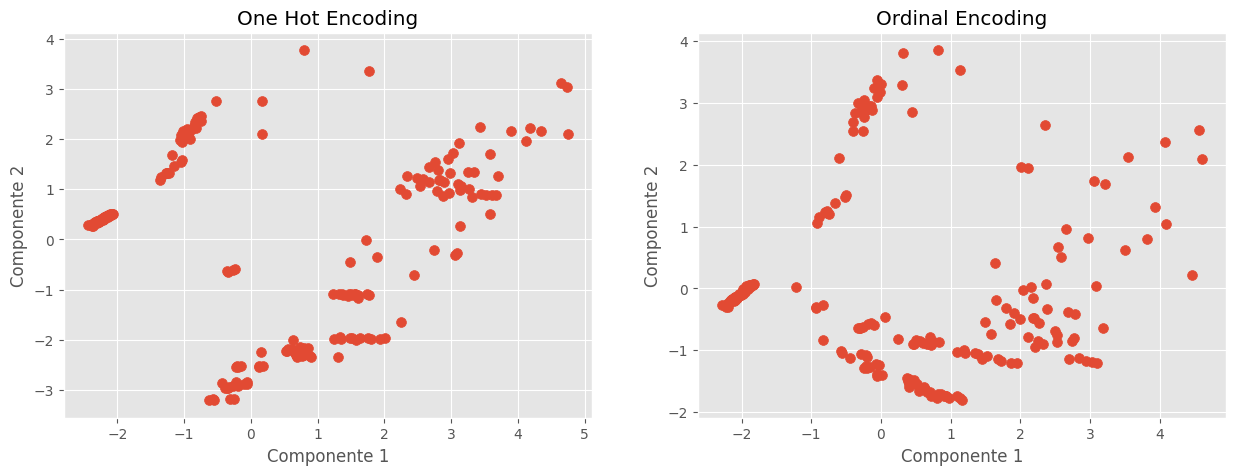

In [197]:
scaler = StandardScaler()
pca = PCA(n_components=2)

one_hot_scaled = scaler.fit_transform(one_hot_df)
ordinal_scaled = scaler.fit_transform(ordinal_df)

# Reducción de la dimensionalidad

X_one_hot_pca = pca.fit_transform(one_hot_scaled)
X_ordinal_pca = pca.fit_transform(ordinal_scaled)

# Represenantamos los datos en dos gráficas diferentes
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].scatter(X_one_hot_pca[:, 0], X_one_hot_pca[:, 1], s=50)
axs[0].set_title('One Hot Encoding')
axs[0].set_xlabel('Componente 1')
axs[0].set_ylabel('Componente 2')

axs[1].scatter(X_ordinal_pca[:, 0], X_ordinal_pca[:, 1], s=50)
axs[1].set_title('Ordinal Encoding')
axs[1].set_xlabel('Componente 1')
axs[1].set_ylabel('Componente 2')

plt.show()


Tras haber transformado los valores categóricos a númericos con los 2 métodos de transformación, asignadoles valores ordinales y a traves de la transformación one hot encoding, aplicamos un pca para reducir la dimensionalidad de los datos a 2 variables y para así poder ejecutar luego el k-means. Observamos la diferencia entre los PCA a la hora de simular los datos debido a los diferentes valores que toman las columnas 'color' y 'espectral class' tras las transformaciones. 

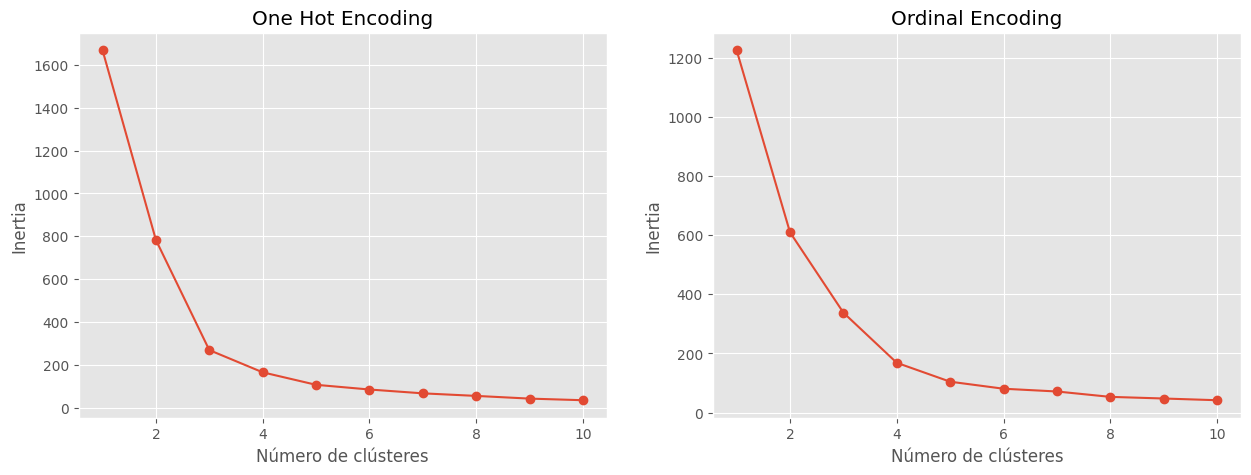

In [198]:

# Número óptimo de clústeres
# ==============================================================================
inertia_oh = []
inertia_ordinal = []
for i in range(1, 11):
    kmeans_inertia = KMeans(n_clusters=i, random_state=123).fit(X_ordinal_pca)
    inertia_ordinal.append(kmeans_inertia.inertia_)

for i in range(1, 11):
    kmeans_inertia = KMeans(n_clusters=i, random_state=123).fit(X_one_hot_pca)
    inertia_oh.append(kmeans_inertia.inertia_)

# Representación de los dato en dos gráficos
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(range(1, 11), inertia_oh, marker='o')
axs[0].set_title('One Hot Encoding')
axs[0].set_xlabel('Número de clústeres')
axs[0].set_ylabel('Inertia')

axs[1].plot(range(1, 11), inertia_ordinal, marker='o')
axs[1].set_title('Ordinal Encoding')
axs[1].set_xlabel('Número de clústeres')
axs[1].set_ylabel('Inertia')

plt.show()


El propósito de trazar este gráfico es identificar el punto de inflexión, donde la disminución en la inercia disminuye significativamente. Este punto indica el número óptimo de clústeres para el conjunto de datos dado. La elección del número de clústeres adecuado es crucial para obtener clústeres significativos y útiles en el análisis de los datos.

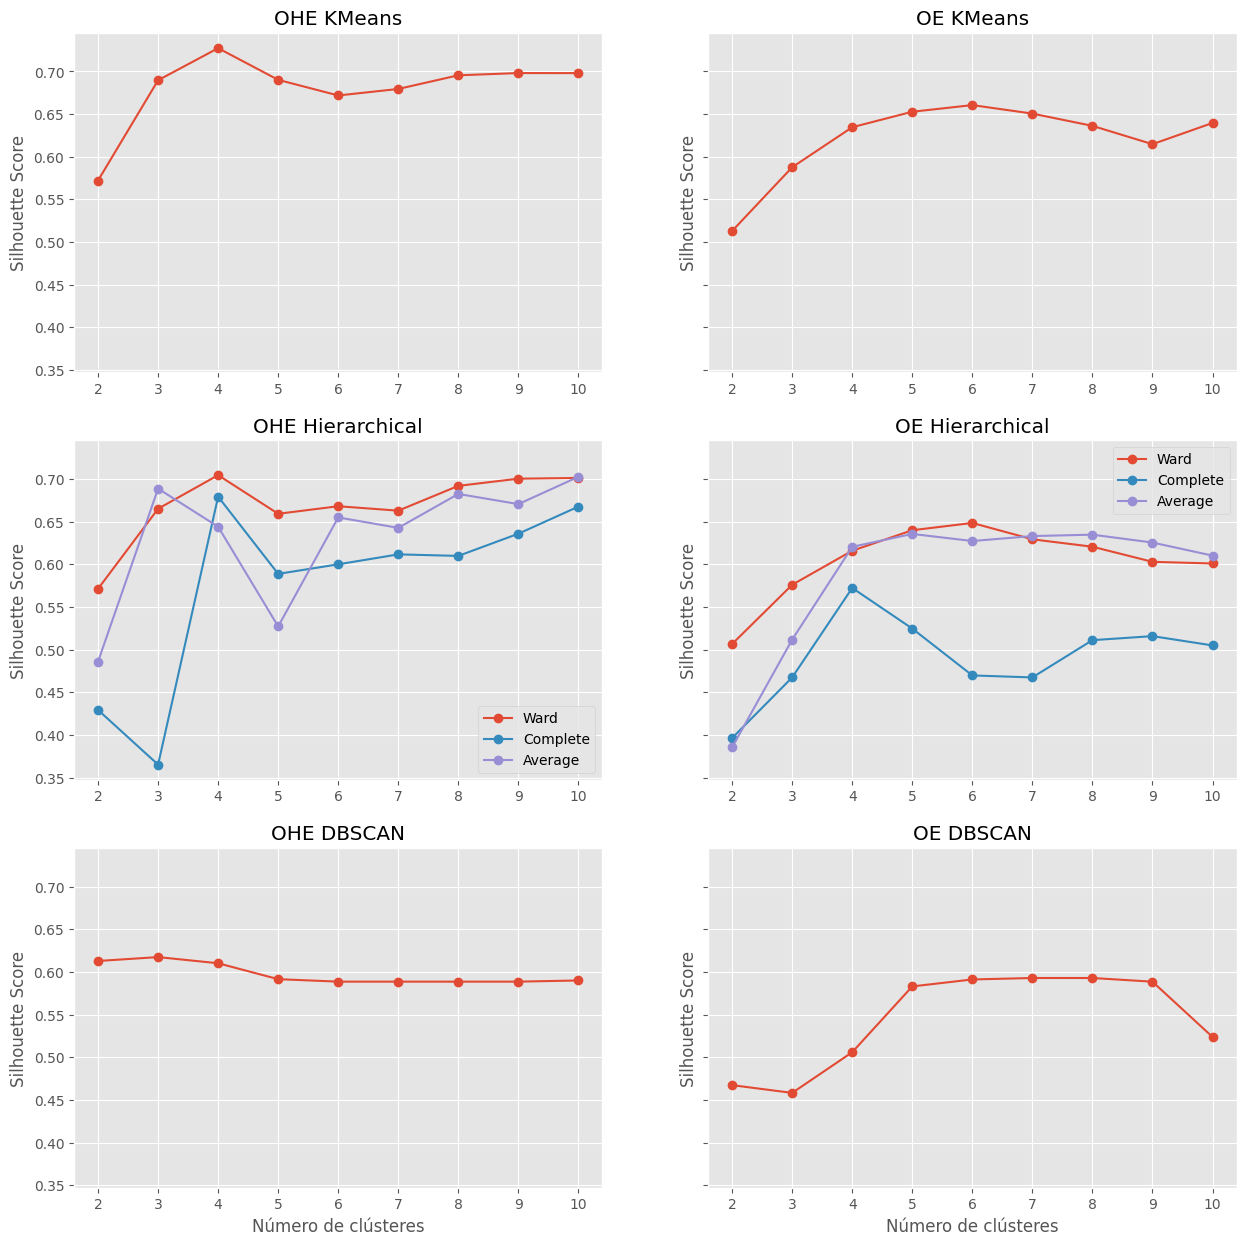

In [213]:
# Silhouette Score
silhouette_oh = []
silhouette_ordinal = []
for i in range(2, 11):
    kmeans_silhouette = KMeans(n_clusters=i, random_state=123).fit_predict(X_one_hot_pca)
    silhouette_oh.append(silhouette_score(X_one_hot_pca, kmeans_silhouette))

    kmeans_silhouette_oe = KMeans(n_clusters=i, random_state=123).fit_predict(X_ordinal_pca)
    silhouette_ordinal.append(silhouette_score(X_ordinal_pca, kmeans_silhouette_oe))

# silhouette for hierarchical clustering
silhouette_hc_oh = []
silhouette_hc_ordinal = []
silhouette_hierarchical_oh_complete = []
silhouette_hierarchical_ordinal_complete = []
silhouette_hierarchical_oh_average = []
silhouette_hierarchical_ordinal_average = []
for i in range(2, 11):
    hc = AgglomerativeClustering(n_clusters=i, linkage='ward').fit_predict(X_one_hot_pca)
    silhouette_hc_oh.append(silhouette_score(X_one_hot_pca, hc))
    hc = AgglomerativeClustering(n_clusters=i, linkage='complete').fit_predict(X_one_hot_pca)
    silhouette_hierarchical_oh_complete.append(silhouette_score(X_one_hot_pca, hc))
    hc = AgglomerativeClustering(n_clusters=i, linkage='average').fit_predict(X_one_hot_pca)
    silhouette_hierarchical_oh_average.append(silhouette_score(X_one_hot_pca, hc))

    hc = AgglomerativeClustering(n_clusters=i, linkage='ward').fit_predict(X_ordinal_pca)
    silhouette_hc_ordinal.append(silhouette_score(X_ordinal_pca, hc))
    hc = AgglomerativeClustering(n_clusters=i, linkage='complete').fit_predict(X_ordinal_pca)
    silhouette_hierarchical_ordinal_complete.append(silhouette_score(X_ordinal_pca, hc))
    hc = AgglomerativeClustering(n_clusters=i, linkage='average').fit_predict(X_ordinal_pca)
    silhouette_hierarchical_ordinal_average.append(silhouette_score(X_ordinal_pca, hc))


# silhouette for DBSCAN
silhouette_dbscan_oh = []
silhouette_dbscan_ordinal = []
for i in range(2, 11):
    dbscan = DBSCAN(eps=0.5, min_samples=i).fit_predict(X_one_hot_pca)
    silhouette_dbscan_oh.append(silhouette_score(X_one_hot_pca, dbscan))

    dbscan = DBSCAN(eps=0.5, min_samples=i).fit_predict(X_ordinal_pca)
    silhouette_dbscan_ordinal.append(silhouette_score(X_ordinal_pca, dbscan))

# en seis graficos tres para cada modelos de codificación
fig, axs = plt.subplots(3, 2, figsize=(15, 15), sharey=True)

axs[0, 0].plot(range(2, 11), silhouette_oh, marker='o')
axs[0, 0].set_title('OHE KMeans')
axs[0, 0].set_ylabel('Silhouette Score')

axs[0, 1].plot(range(2, 11), silhouette_ordinal, marker='o')
axs[0, 1].set_title('OE KMeans')
axs[0, 1].set_ylabel('Silhouette Score')

#agrupa en hierarchical por cada tipo de link
axs[1, 0].plot(range(2, 11), silhouette_hc_oh, marker='o')
axs[1, 0].plot(range(2, 11), silhouette_hierarchical_oh_complete, marker='o')
axs[1, 0].plot(range(2, 11), silhouette_hierarchical_oh_average, marker='o')
axs[1, 0].set_title('OHE Hierarchical')
axs[1, 0].set_ylabel('Silhouette Score')

axs[1, 1].plot(range(2, 11), silhouette_hc_ordinal, marker='o')
axs[1, 1].plot(range(2, 11), silhouette_hierarchical_ordinal_complete, marker='o')
axs[1, 1].plot(range(2, 11), silhouette_hierarchical_ordinal_average, marker='o')
axs[1, 1].set_title('OE Hierarchical')
axs[1, 1].set_ylabel('Silhouette Score')

#agrupa en dbscan
axs[2, 0].plot(range(2, 11), silhouette_dbscan_oh, marker='o')
axs[2, 0].set_title('OHE DBSCAN')
axs[2, 0].set_xlabel('Número de clústeres')
axs[2, 0].set_ylabel('Silhouette Score')

axs[2, 1].plot(range(2, 11), silhouette_dbscan_ordinal, marker='o')
axs[2, 1].set_title('OE DBSCAN')
axs[2, 1].set_xlabel('Número de clústeres')
axs[2, 1].set_ylabel('Silhouette Score')

axs[1, 0].legend(['Ward', 'Complete', 'Average'])
axs[1, 1].legend(['Ward', 'Complete', 'Average'])

plt.show()



El propósito de trazar estos gráficos es identificar el número óptimo de clústeres que maximiza el Silhouette Score. Un Silhouette Score más alto indica una mejor calidad de clustering. Por lo tanto, el número óptimo de clústeres generalmente se elige donde el Silhouette Score alcanza su valor máximo. Vemos que para los datos transformados en ordinal encoding el mejor modelo que se ajusta es hieraechical, mientras que en los datos one hot encoding es Kmeans.
Asi mismo, estos gráficos actuan a modo de ajuste de hiperparametros, ya que de cada tipo de modelo se obtienen los mejores parametros.Es por eso que podemos observar que el mejor modelo usando Hierarchical clustering es usando como parametro el linkage tipo *ward*.

In [200]:
times_score = []
silhouette_scores = []

## 3.2.- Modelos para One Hot Encoding

### Algoritmo Kmeans

Iteración final:  4
Centroides finales:  [[-0.21762153 -2.83162543]
 [-1.86065987  0.85169618]
 [ 1.14338483 -1.63542222]
 [ 3.1447558   1.36143512]]


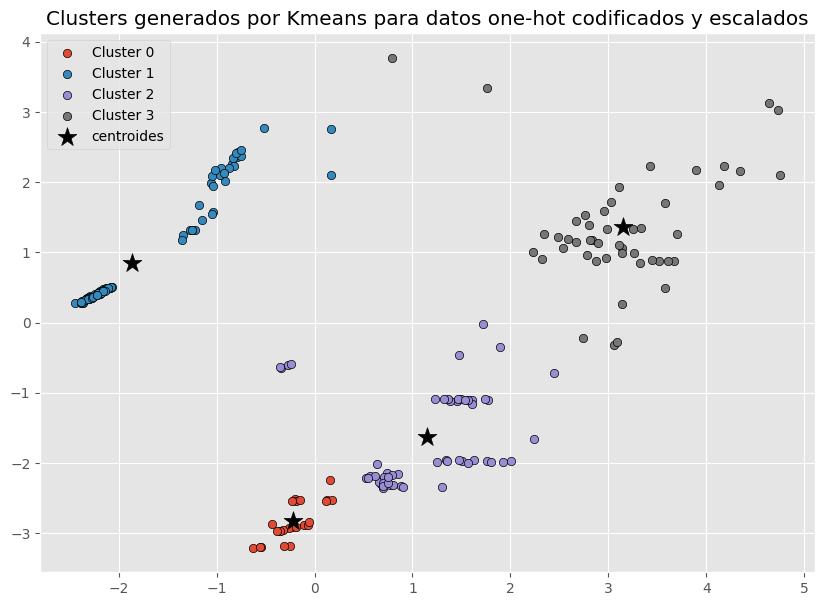

Tiempo de ejecución: 0.03970837593078613 segundos
Silhouette Score: 0.6400466302609082


In [201]:
# Aplicar KMeans a los datos transformados por PCA
n_clusters = 4
start = time.time()
centroides, asignaciones = kmeans(X_one_hot_pca, n_clusters)

silhouette_kmeans = silhouette_score(X_one_hot_pca, asignaciones)

end = time.time()

plt.figure(figsize=(10, 7))
for i in np.unique(asignaciones):
    plt.scatter(
        x = X_one_hot_pca[np.array(asignaciones) == i, 0],
        y = X_one_hot_pca[np.array(asignaciones) == i, 1],
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i % len(plt.rcParams['axes.prop_cycle'].by_key()['color'])],
        marker    = 'o',
        edgecolor = 'black',
        label= f"Cluster {i}"
    )

plt.scatter(
    x = centroides[:, 0],
    y = centroides[:, 1],
    c = 'black',
    s = 200,
    marker = '*',
    label  = 'centroides'
)
plt.title('Clusters generados por Kmeans para datos one-hot codificados y escalados')
plt.legend()
plt.show()
print(f"Tiempo de ejecución: {end - start} segundos")
print(f"Silhouette Score: {silhouette_kmeans}")

times_score.append({"time": end - start, "algorithm": "Custom Kmeans"})
silhouette_scores.append({"score": silhouette_kmeans, "algorithm": "Custom Kmeans"})


### Kmeans scikit

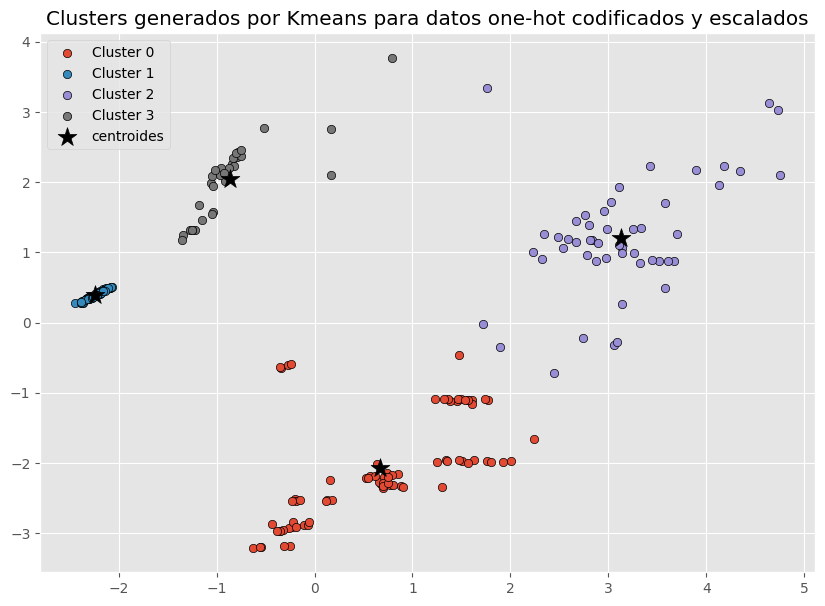

Tiempo de ejecución: 0.028626441955566406 segundos
Silhouette Score: 0.7272977616753254


In [202]:
# Kmeans with scikit-learn
start = time.time()
kmeans_scikit = KMeans(n_clusters=4, random_state=23)
kmeans_scikit.fit(X_one_hot_pca)
y_predict = kmeans_scikit.predict(X_one_hot_pca)

# Show the silhouette score
silhouette = silhouette_score(X_one_hot_pca, y_predict)

end = time.time()

plt.figure(figsize=(10, 7))
for i in np.unique(y_predict):
    plt.scatter(
        x = X_one_hot_pca[y_predict == i, 0],
        y = X_one_hot_pca[y_predict == i, 1],
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i % len(plt.rcParams['axes.prop_cycle'].by_key()['color'])],
        marker    = 'o',
        edgecolor = 'black',
        label= f"Cluster {i}"
    )

plt.scatter(
    x = kmeans_scikit.cluster_centers_[:, 0],
    y = kmeans_scikit.cluster_centers_[:, 1],
    c = 'black',
    s = 200,
    marker = '*',
    label  = 'centroides'
)

plt.title('Clusters generados por Kmeans para datos one-hot codificados y escalados')
plt.legend()
plt.show()

print(f"Tiempo de ejecución: {end - start} segundos")
print(f"Silhouette Score: {silhouette}")

times_score.append({"time": end - start, "algorithm": "KMeans scikit-learn OHE"})
silhouette_scores.append({"score": silhouette, "algorithm": "KMeans scikit-learn OHE"})

### Hierarchical cluster

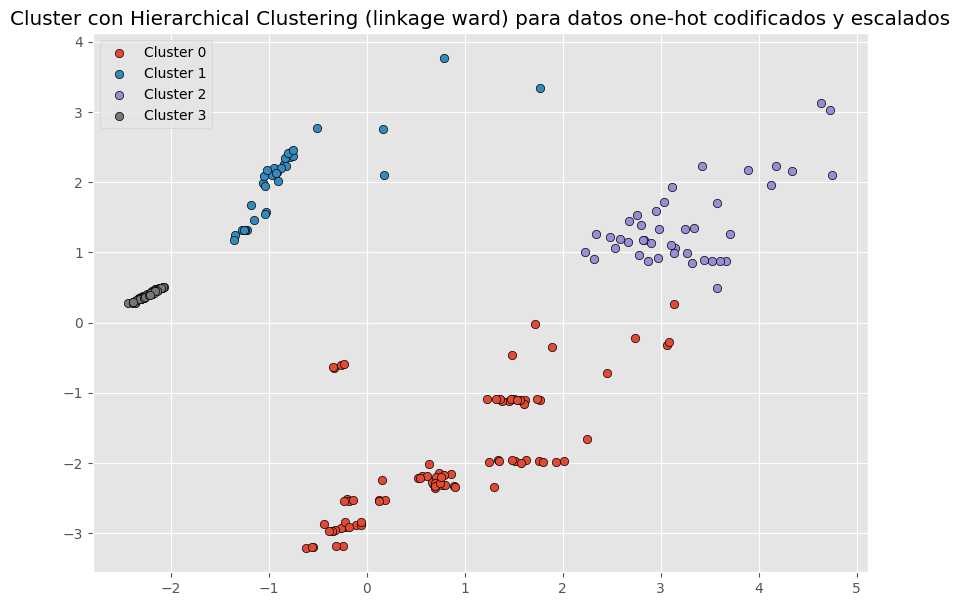

Tiempo de ejecución: 0.0029993057250976562 segundos
Silhouette Score: 0.7046251494177559


In [203]:
start = time.time()
# Clustering jerárquico
hc = AgglomerativeClustering(n_clusters=4, linkage = 'ward')
y_hc = hc.fit_predict(X_one_hot_pca)

# Show the silhouette score
silhouette_hc = silhouette_score(X_one_hot_pca, y_hc)

end = time.time()

plt.figure(figsize=(10, 7))
for i in np.unique(y_hc):
    plt.scatter(
        x = X_one_hot_pca[np.array(y_hc) == i, 0],
        y = X_one_hot_pca[np.array(y_hc) == i, 1],
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i % len(plt.rcParams['axes.prop_cycle'].by_key()['color'])],
        marker = 'o',
        edgecolor = 'black',
        label= f"Cluster {i}"
    )
plt.title('Cluster con Hierarchical Clustering (linkage ward) para datos one-hot codificados y escalados')
plt.legend()
plt.show()

print(f"Tiempo de ejecución: {end - start} segundos")
print(f"Silhouette Score: {silhouette_hc}")
 
times_score.append({"time": end - start, "algorithm": "Hierarchical Clustering (link ward) OHE"})
silhouette_scores.append({"score": silhouette_hc, "algorithm": "Hierarchical Clustering (link ward) OHE"})


### DBSCAN

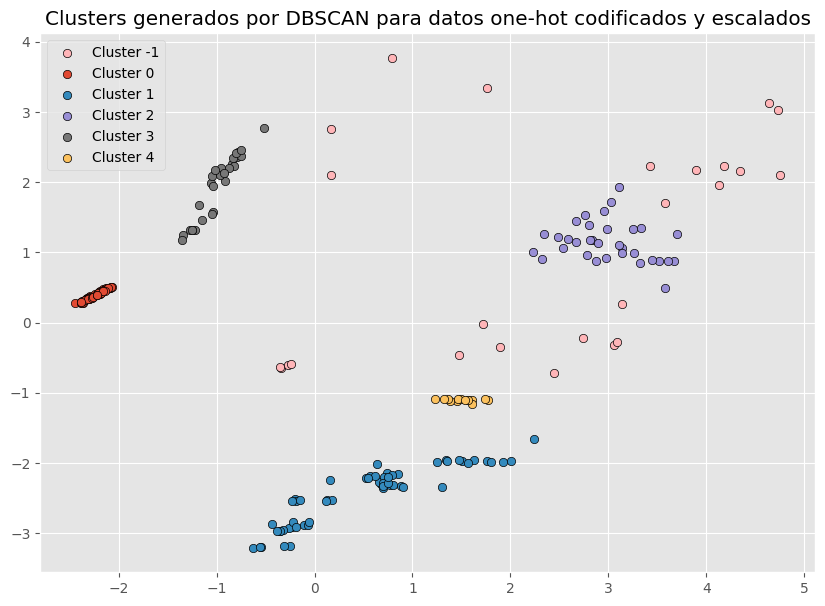

Tiempo de ejecución: 0.003993511199951172 segundos
Silhouette Score: 0.5838713969407446


In [204]:
start = time.time()
# Entrenamos el modelo
dbscan = DBSCAN(eps=0.4, min_samples=5, metric= 'euclidean')
dbscan.fit(X_one_hot_pca)

# Show the silhouette score
silhouette_dbscan = silhouette_score(X_one_hot_pca, dbscan.labels_)

end = time.time()
# Representamos los resultados
labels = dbscan.labels_

# show clusters
plt.figure(figsize=(10, 7))
for i in np.unique(labels):
    plt.scatter(
        x = X_one_hot_pca[labels == i, 0],
        y = X_one_hot_pca[labels == i, 1],
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i % len(plt.rcParams['axes.prop_cycle'].by_key()['color'])],
        marker = 'o',
        edgecolor = 'black',
        label= f"Cluster {i}"
    )

plt.title('Clusters generados por DBSCAN para datos one-hot codificados y escalados')
plt.legend()
plt.show()

print(f"Tiempo de ejecución: {end - start} segundos")
print(f"Silhouette Score: {silhouette_dbscan}")

times_score.append({"time": end - start, "algorithm": "DBSCAN OHE"})
silhouette_scores.append({"score": silhouette_dbscan, "algorithm": "DBSCAN OHE"})

## 3.3.- Modelos con Ordinal Encoding

### Kmeans propio

Iteración final:  4
Centroides finales:  [[-0.29079621 -0.90770912]
 [-2.02205121 -0.10007725]
 [ 0.90999306 -1.31236532]
 [ 2.74960727  0.10699807]
 [-0.71666571  1.35725052]
 [ 0.06378674  3.05551488]]


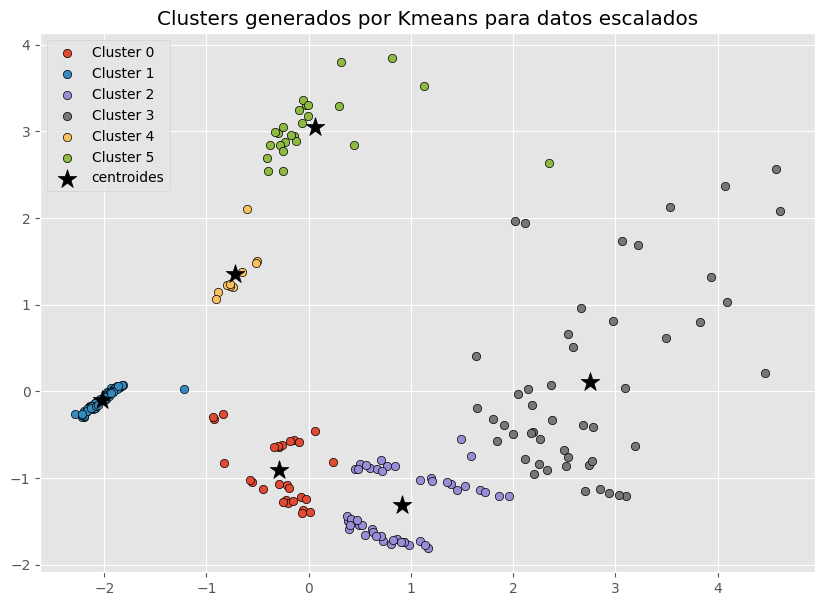

Tiempo de ejecución: 0.06231498718261719 segundos
Silhouette Score: 0.6019428774850948


In [205]:
n_clusters = 6
# Aplicar KMeans a los datos transformados por PCA
start = time.time()
centroides_oe, asignaciones_oe = kmeans(X_ordinal_pca, n_clusters)

# Show the silhouette score
silhouette_oe = silhouette_score(X_ordinal_pca, asignaciones_oe)

end = time.time()
plt.figure(figsize=(10, 7))
for i in np.unique(asignaciones_oe):
    plt.scatter(
        x = X_ordinal_pca[np.array(asignaciones_oe) == i, 0],
        y = X_ordinal_pca[np.array(asignaciones_oe) == i, 1],
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i % len(plt.rcParams['axes.prop_cycle'].by_key()['color'])],
        marker = 'o',
        edgecolor = 'black',
        label= f"Cluster {i}"
    )

plt.scatter(
    x = centroides_oe[:, 0],
    y = centroides_oe[:, 1],
    c = 'black',
    s = 200,
    marker = '*',
    label  = 'centroides'
)
plt.title('Clusters generados por Kmeans para datos escalados')
plt.legend()
plt.show()
print(f"Tiempo de ejecución: {end - start} segundos")
print(f"Silhouette Score: {silhouette_oe}")

times_score.append({"time": end - start, "algorithm": "Custom Kmeans OE"})
silhouette_scores.append({"score": silhouette_oe, "algorithm": "Custom Kmeans OE"})

### Kmean scikit

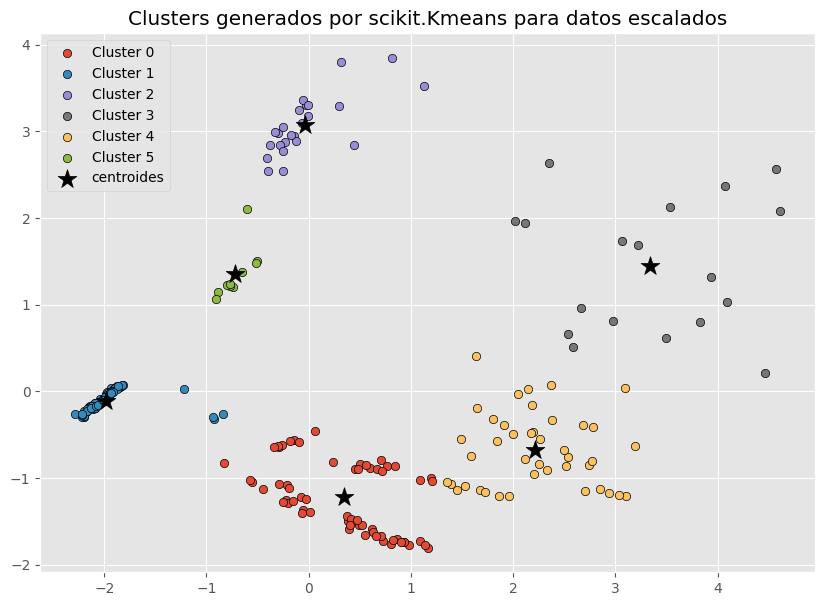

Tiempo de ejecución: 0.033769845962524414 segundos
Silhouette Score: 0.6605298437727174


In [206]:
start = time.time()
kmeans_scikit_oe = KMeans(n_clusters=6, random_state=23)
kmeans_scikit_oe.fit(X_ordinal_pca)
y_predict=kmeans_scikit_oe.predict(X_ordinal_pca)

# Show the silhouette score
silhouette = silhouette_score(X_ordinal_pca, y_predict)

end = time.time()

plt.figure(figsize=(10, 7))
for i in np.unique(y_predict):
    plt.scatter(
        x = X_ordinal_pca[np.array(y_predict) == i, 0],
        y = X_ordinal_pca[np.array(y_predict) == i, 1],
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i % len(plt.rcParams['axes.prop_cycle'].by_key()['color'])],
        marker = 'o',
        edgecolor = 'black',
        label= f"Cluster {i}"
    )

plt.scatter(
    kmeans_scikit_oe.cluster_centers_[:, 0],
    kmeans_scikit_oe.cluster_centers_[:, 1],
    s = 200,
    c = 'black',
    marker = '*',
    label  = 'centroides'
)
plt.title('Clusters generados por scikit.Kmeans para datos escalados')
plt.legend()
plt.show()
print(f"Tiempo de ejecución: {end - start} segundos")
print(f"Silhouette Score: {silhouette}")

times_score.append({"time": end - start, "algorithm": "KMeans scikit-learn OE"})
silhouette_scores.append({"score": silhouette, "algorithm": "KMeans scikit-learn OE"})

### Hierarchical Clustering

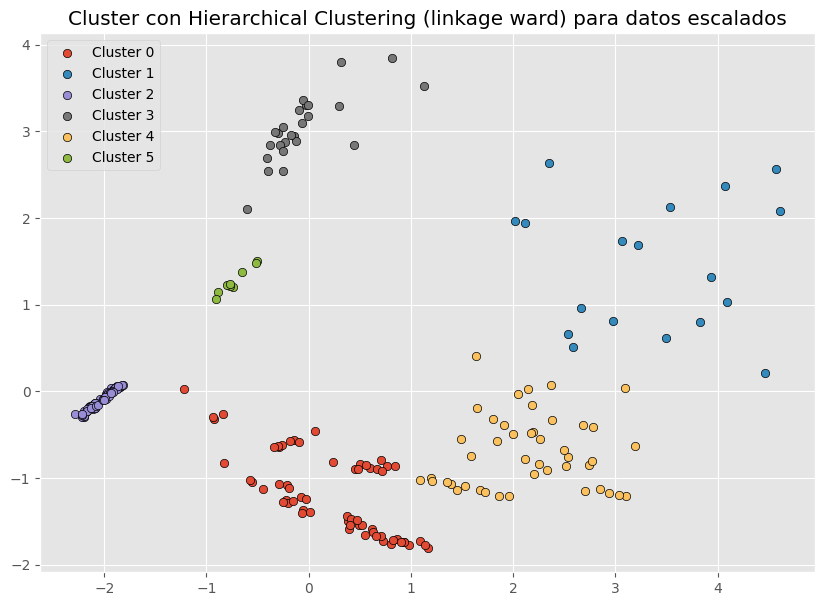

Tiempo de ejecución: 0.005015373229980469 segundos
Silhouette Score: 0.6485576686067179


In [207]:
# Clustering jerárquico
start = time.time()
hc = AgglomerativeClustering(n_clusters=6, linkage = 'ward')
y_hc = hc.fit_predict(X_ordinal_pca)

# Show the silhouette score
silhouette_hc = silhouette_score(X_ordinal_pca, y_hc)

end = time.time()

plt.figure(figsize=(10, 7))

for i in np.unique(y_hc):
    plt.scatter(
        x = X_ordinal_pca[np.array(y_hc) == i, 0],
        y = X_ordinal_pca[np.array(y_hc) == i, 1],
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i % len(plt.rcParams['axes.prop_cycle'].by_key()['color'])],
        marker = 'o',
        edgecolor = 'black',
        label= f"Cluster {i}"
    )
plt.title('Cluster con Hierarchical Clustering (linkage ward) para datos escalados')
plt.legend()
plt.show()

print(f"Tiempo de ejecución: {end - start} segundos")
print(f"Silhouette Score: {silhouette_hc}")

times_score.append({"time": end - start, "algorithm": "Hierarchical Clustering (link ward) OE"})
silhouette_scores.append({"score": silhouette_hc, "algorithm": "Hierarchical Clustering (link ward) OE"})

### DBSCAN

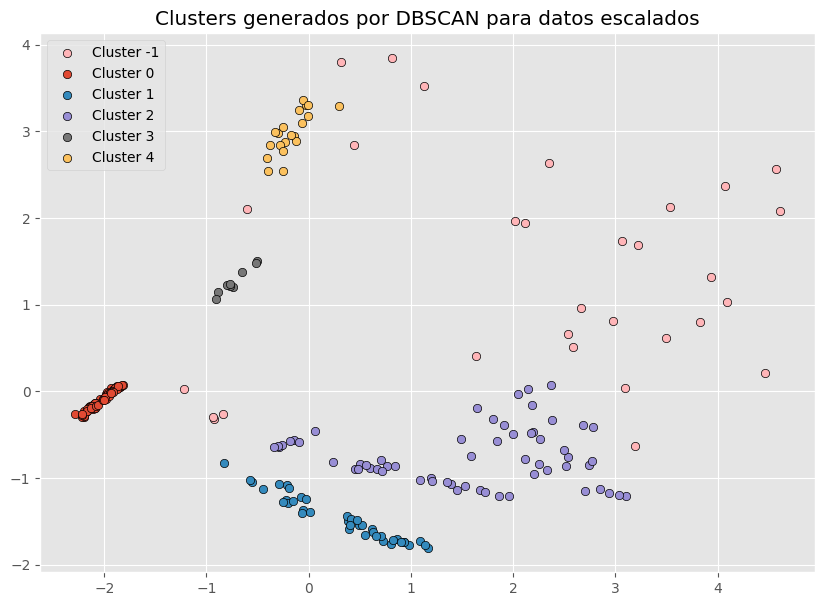

Tiempo de ejecución: 0.0031130313873291016 segundos
Silhouette Score: 0.5188282693189505


In [208]:
# dbscan
start = time.time()
dbscan = DBSCAN(eps=0.4, min_samples=5, metric= 'euclidean')
dbscan.fit(X_ordinal_pca)

# Show the silhouette score
silhouette_dbscan = silhouette_score(X_ordinal_pca, dbscan.labels_)

end = time.time()

labels = dbscan.labels_

# show clusters
plt.figure(figsize=(10, 7))
for i in np.unique(labels):
    plt.scatter(
        x = X_ordinal_pca[labels == i, 0],
        y = X_ordinal_pca[labels == i, 1],
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i % len(plt.rcParams['axes.prop_cycle'].by_key()['color'])],
        marker = 'o',
        edgecolor = 'black',
        label= f"Cluster {i}"
    )

plt.title('Clusters generados por DBSCAN para datos escalados')
plt.legend()
plt.show()

print(f"Tiempo de ejecución: {end - start} segundos")
print(f"Silhouette Score: {silhouette_dbscan}")

times_score.append({"time": end - start, "algorithm": "DBSCAN OE"})
silhouette_scores.append({"score": silhouette_dbscan, "algorithm": "DBSCAN OE"})

# 4.- Pipeline con el mejor modelo

Mostramos los resultados obtenidos para cada modelo

Tiempos de ejecución de los algoritmos:


,time,algorithm
0,0.039708,Custom Kmeans
1,0.028626,KMeans scikit-learn OHE
2,0.002999,Hierarchical Clustering (link ward) OHE
3,0.003994,DBSCAN OHE
4,0.062315,Custom Kmeans OE
5,0.033770,KMeans scikit-learn OE
6,0.005015,Hierarchical Clustering (link ward) OE
7,0.003113,DBSCAN OE


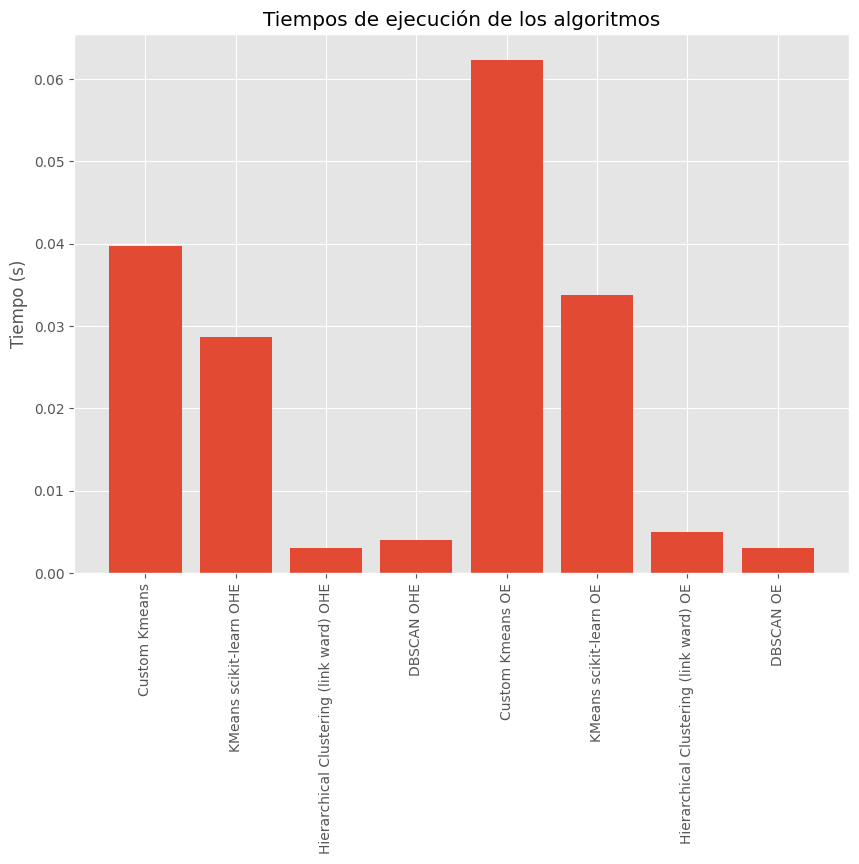

In [209]:
# Show the results
times_score_df = pd.DataFrame(times_score)

print("Tiempos de ejecución de los algoritmos:")
display(times_score_df)

# Bar plot
plt.figure(figsize=(10, 7))
plt.bar(times_score_df.algorithm, times_score_df.time)
plt.title('Tiempos de ejecución de los algoritmos')
plt.ylabel('Tiempo (s)')
plt.xticks(rotation=90)
plt.show()

Silhouette Scores de los algoritmos:


,score,algorithm
0,0.640047,Custom Kmeans
1,0.727298,KMeans scikit-learn OHE
2,0.704625,Hierarchical Clustering (link ward) OHE
3,0.583871,DBSCAN OHE
4,0.601943,Custom Kmeans OE
5,0.660530,KMeans scikit-learn OE
6,0.648558,Hierarchical Clustering (link ward) OE
7,0.518828,DBSCAN OE


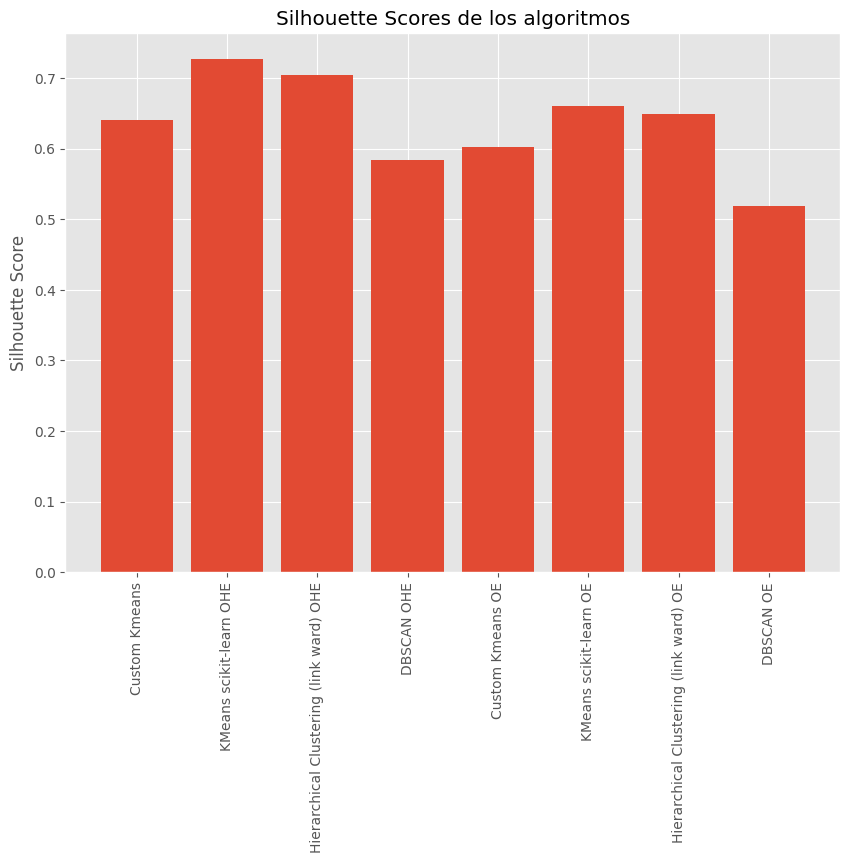

In [210]:
# Show the results
silhouette_scores_df = pd.DataFrame(silhouette_scores)

print("Silhouette Scores de los algoritmos:")
display(silhouette_scores_df)

# Bar plot
plt.figure(figsize=(10, 7))
plt.bar(silhouette_scores_df.algorithm, silhouette_scores_df.score)
plt.title('Silhouette Scores de los algoritmos')
plt.ylabel('Silhouette Score')
plt.xticks(rotation=90)
plt.show()

## Pipeline Mejor modelo para datos One Hot Encoded

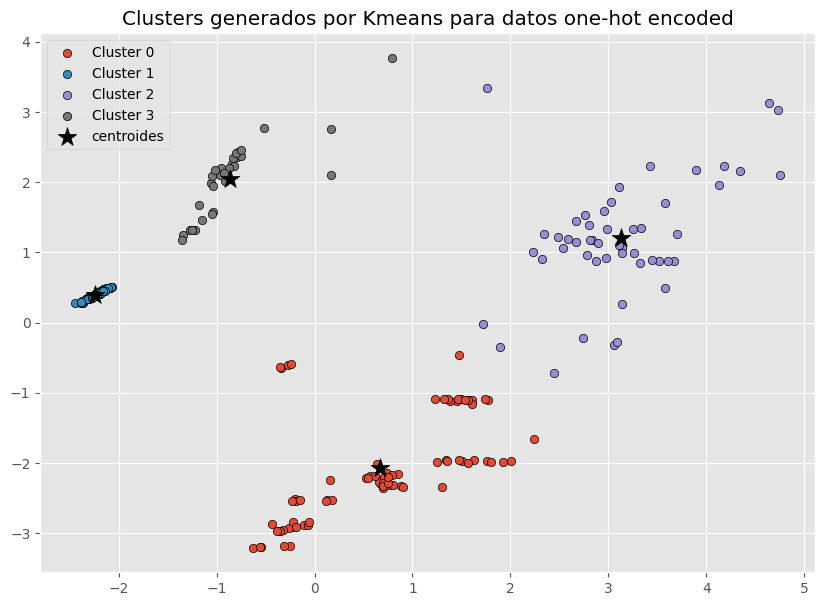

In [211]:
# pipeline del kmean de sci-kit learn para los datos one hot encoded

from sklearn.pipeline import Pipeline

# Creamos la pipeline
kmeans_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=2)),
    ('kmeans', KMeans(n_clusters=4, random_state=23))
])

# Entrenamos la pipeline y los resultados
kmeans_pipeline.fit(one_hot_df)
y_predict = kmeans_pipeline.fit_predict(one_hot_df)
plt.figure(figsize=(10, 7))
for i in np.unique(y_predict):
    plt.scatter(
        x = X_one_hot_pca[y_predict == i, 0],
        y = X_one_hot_pca[y_predict == i, 1],
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i % len(plt.rcParams['axes.prop_cycle'].by_key()['color'])],
        marker    = 'o',
        edgecolor = 'black',
        label= f"Cluster {i}"
    )

plt.scatter(
    x = kmeans_pipeline.named_steps['kmeans'].cluster_centers_[:, 0],
    y = kmeans_pipeline.named_steps['kmeans'].cluster_centers_[:, 1],
    c = 'black',
    s = 200,
    marker = '*',
    label  = 'centroides'
)
plt.title('Clusters generados por Kmeans para datos one-hot encoded')
plt.legend()
plt.show()


